In [2]:
import pandas as pd
from pybedtools import BedTool
import pybedtools
import panel as pn
pn.extension()

from lab_central_webapp.catalogs import intake_catalog

In [3]:
def intersect_bed_dfs(df1, df2):
    columns_list = df1.rename(columns = {"chrom": "chrom_1", "start": "start_1", "stop": "stop_1", "peak": "peak_1"}).columns.tolist() + df2.rename(columns = {"chrom": "chrom_2", "start": "start_2", "stop": "stop_2", "peak": "peak_2"}).columns.tolist()
    
    
    df = BedTool.from_dataframe(df1, header = df1.columns.tolist())\
.intersect(BedTool.from_dataframe(df2, header = df2.columns.tolist()), wa= True, wb = True).to_dataframe(disable_auto_names= True).T.reset_index().T.reset_index(drop = True)
    
    df.columns = columns_list
    pybedtools.cleanup(remove_all=True)
    
    return df

In [4]:
def plot_cell_type_merged_bingren(peak_list_df, col= "cell_type_name_exploded", num_display_cell_type = 20, p_value_thresh = None):
    data_df = intersect_bed_dfs()
    plot_df = data_df.assign(cell_type_name_exploded = data_df.cell_type_name.str.split(","),
                            cell_type_exploded = data_df.cell_type.str.split(","))\
    .explode(["cell_type_name_exploded"])
    
    plot_df = plot_df.drop_duplicates(["peak_1", col])
    if p_value_thresh:
        plot_df["p_value"] = plot_df["p_value"].astype(float)
        plot_df = plot_df.query("p_value < @p_value_thresh")
    
    display(plot_df.groupby("peak_1")["cell_type_name_exploded"].nunique().sort_values())
    cell_type_count = plot_df.drop_duplicates(["peak_1", "cell_type_name_exploded"])[col].value_counts()
    display(cell_type_count)
    if num_display_cell_type:
        display_cell_types = cell_type_count.head(num_display_cell_type).index.tolist() + cell_type_count.tail(num_display_cell_type).index.tolist()
        display_plot_df = plot_df.set_index(col).loc[display_cell_types].reset_index()#"cell_type_name_exploded in @display_cell_types")
        display_cell_types_top_only = cell_type_count.head(num_display_cell_type*2).index.tolist()
        display(px.histogram(display_plot_df, x = col, height = 500))
        return pd.crosstab(plot_df["peak_1"], columns = plot_df["cell_type_name_exploded"])[display_cell_types_top_only]
    else:
        return pd.crosstab(plot_df["peak_1"], columns = plot_df["cell_type_name_exploded"])

In [5]:
bingren_scATAC = intake_catalog.load_data("yang_2022_brain_scATAC")
bingren_scATAC

,chrom,start,stop,cCRE_ID,cell_type,peak,cell_type_name
0,chr1,9848,10347,cCRE_1,"AMY,ASCT_1,ASCT_2,ASCT_3,COP,ERC_1,ITL23_1,ITL...",chr1_9848_10347,"Glutamatergic neurons from amygdala,Telencepha..."
1,chr1,180570,181069,cCRE_2,"ACBGM,AMY,ASCNT_1,ASCNT_3,ASCT_1,ASCT_2,ASCT_3...",chr1_180570_181069,"Bergmann glia,Glutamatergic neurons from amygd..."
2,chr1,191227,191726,cCRE_3,"ASCNT_1,ASCNT_2,ASCNT_3,ASCT_1,ASCT_2,ASCT_3,C...",chr1_191227_191726,"Non-telencephalon astrocytes - type 1,Non-tele..."
3,chr1,267759,268258,cCRE_4,"ASCT_2,ASCT_3,OGC_1,OGC_2,OGC_3,OPC",chr1_267759_268258,"Telencephalon astrocytes - type 2,Telencephalo..."
4,chr1,585948,586447,cCRE_5,"ASCT_2,OGC_2,OGC_3,OPC",chr1_585948_586447,"Telencephalon astrocytes - type 2,Oligodendroc..."
...,...,...,...,...,...,...,...
92827,chrY,56727893,56728392,cCRE_544731,"ACBGM,ASCNT_1,ASCT_1,ASCT_2,ASCT_3,CBGRC,ITL23...",chrY_56727893_56728392,"Bergmann glia,Non-telencephalon astrocytes - t..."
92828,chrY,56734541,56735040,cCRE_544732,"ASCNT_1,ASCNT_2,ASCNT_3,ASCT_1,ASCT_2,ASCT_3,C...",chrY_56734541_56735040,"Non-telencephalon astrocytes - type 1,Non-tele..."
92829,chrY,56742465,56742964,cCRE_544733,"ASCT_1,OGC_1",chrY_56742465_56742964,"Telencephalon astrocytes - type 1,Oligodendroc..."
92830,chrY,56763271,56763770,cCRE_544734,"AMY,ASCNT_1,ASCT_1,ASCT_2,ASCT_3,BFEXA,CBGRC,C...",chrY_56763271_56763770,"Glutamatergic neurons from amygdala,Non-telenc..."


In [ ]:
bingren_scATAC

Column(width_policy='max')
    [0] Row(width_policy='max')
        [0] PNG(str)
        [1] Column(width_policy='max')
            [0] Column(name='Select Catalog')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options={'builtin': <Intake c...}, size=9, value=[<Intake catalog: b...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='＋', width=50)
                [1] Button(name='―', width=50)
                [2] Toggle(name='🔍', width=50)
        [2] Column(width_policy='max')
            [0] Column(name='Select Data Source')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, size=9, width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(disabled=True, name='📊', width=50)
                [1] Toggle(disabled=True, name='⚙', width=50)
        [3] Column(height=240, name='Description', scroll=True, sizing_mode='stretch_width', width_policy='max')
            [0] Markdown(str)
    [1] Row(width_policy='max')
        [0] Row(height_policy='min', max_width=5000, name='Search', width_policy='max')
        [1] Column(max_width=5000, name='Add Catalog', width_policy='max')
        [2] Column(name='Plot', width_policy='max')
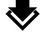

In [3]:
intake.gui

In [13]:
source_entry = intake.gui.sources[0]
data_source = source_entry()
df = data_source.read()

,chrom,start,stop,cCRE_ID,cell_type,peak,cell_type_name
0,chr1,9848,10347,cCRE_1,"AMY,ASCT_1,ASCT_2,ASCT_3,COP,ERC_1,ITL23_1,ITL...",chr1_9848_10347,"Glutamatergic neurons from amygdala,Telencepha..."
1,chr1,180570,181069,cCRE_2,"ACBGM,AMY,ASCNT_1,ASCNT_3,ASCT_1,ASCT_2,ASCT_3...",chr1_180570_181069,"Bergmann glia,Glutamatergic neurons from amygd..."
2,chr1,191227,191726,cCRE_3,"ASCNT_1,ASCNT_2,ASCNT_3,ASCT_1,ASCT_2,ASCT_3,C...",chr1_191227_191726,"Non-telencephalon astrocytes - type 1,Non-tele..."
3,chr1,267759,268258,cCRE_4,"ASCT_2,ASCT_3,OGC_1,OGC_2,OGC_3,OPC",chr1_267759_268258,"Telencephalon astrocytes - type 2,Telencephalo..."
4,chr1,585948,586447,cCRE_5,"ASCT_2,OGC_2,OGC_3,OPC",chr1_585948_586447,"Telencephalon astrocytes - type 2,Oligodendroc..."
...,...,...,...,...,...,...,...
92827,chrY,56727893,56728392,cCRE_544731,"ACBGM,ASCNT_1,ASCT_1,ASCT_2,ASCT_3,CBGRC,ITL23...",chrY_56727893_56728392,"Bergmann glia,Non-telencephalon astrocytes - t..."
92828,chrY,56734541,56735040,cCRE_544732,"ASCNT_1,ASCNT_2,ASCNT_3,ASCT_1,ASCT_2,ASCT_3,C...",chrY_56734541_56735040,"Non-telencephalon astrocytes - type 1,Non-tele..."
92829,chrY,56742465,56742964,cCRE_544733,"ASCT_1,OGC_1",chrY_56742465_56742964,"Telencephalon astrocytes - type 1,Oligodendroc..."
92830,chrY,56763271,56763770,cCRE_544734,"AMY,ASCNT_1,ASCT_1,ASCT_2,ASCT_3,BFEXA,CBGRC,C...",chrY_56763271_56763770,"Glutamatergic neurons from amygdala,Non-telenc..."


In [19]:
data_source.to_dask().head()

,chrom,start,stop,cCRE_ID,cell_type,peak,cell_type_name
0,chr1,9848,10347,cCRE_1,"AMY,ASCT_1,ASCT_2,ASCT_3,COP,ERC_1,ITL23_1,ITL...",chr1_9848_10347,"Glutamatergic neurons from amygdala,Telencepha..."
1,chr1,180570,181069,cCRE_2,"ACBGM,AMY,ASCNT_1,ASCNT_3,ASCT_1,ASCT_2,ASCT_3...",chr1_180570_181069,"Bergmann glia,Glutamatergic neurons from amygd..."
2,chr1,191227,191726,cCRE_3,"ASCNT_1,ASCNT_2,ASCNT_3,ASCT_1,ASCT_2,ASCT_3,C...",chr1_191227_191726,"Non-telencephalon astrocytes - type 1,Non-tele..."
3,chr1,267759,268258,cCRE_4,"ASCT_2,ASCT_3,OGC_1,OGC_2,OGC_3,OPC",chr1_267759_268258,"Telencephalon astrocytes - type 2,Telencephalo..."
4,chr1,585948,586447,cCRE_5,"ASCT_2,OGC_2,OGC_3,OPC",chr1_585948_586447,"Telencephalon astrocytes - type 2,Oligodendroc..."
